In [2]:
!python prepare_dataset.py

Saved 1000 mem and 1000 non-mem indices for nfcorpus in datasets/nfcorpus/selected_indices.json


In [1]:
!python run_mia.py

nohup: ignoring input and redirecting stderr to stdout


# Analysis

In [4]:
import json
import re

output_dir = 'results/target_docs'
output_file = f'{output_dir}/nfcorpus-llama3-Top10-M1000-N10.json'
with open(output_file, 'r') as f:
    data = json.load(f)

def extract_yes_no(answer):
    """Extract 'Yes' or 'No' from a response."""
    match = re.search(r'\b(Yes|No)\b', answer, re.IGNORECASE)
    return match.group(1).capitalize() if match else "Unknown"

all_acc=[]
for doc_id, doc_data in data.items():

    correct_answers = doc_data['answers']
    llm_responses = doc_data['llm_responses']
    total_questions = len(correct_answers)
    correct_count = 0

    # Compare LLM responses with correct answers
    for i in range(total_questions):
        # Extract 'Yes' or 'No' from both the LLM response and the correct answer
        correct_answer = extract_yes_no(correct_answers[i])
        llm_answer = extract_yes_no(llm_responses[i])

        if correct_answer == llm_answer:
            correct_count += 1

    # Calculate accuracy for the document
    accuracy = correct_count / total_questions * 100
    all_acc.append(accuracy)


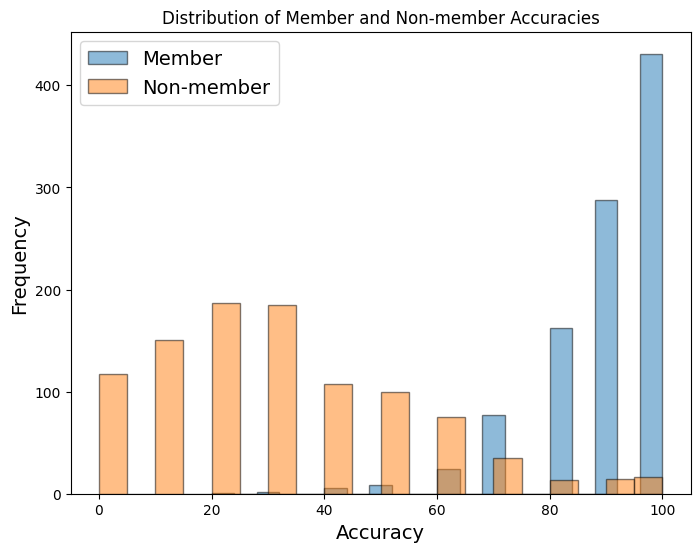

In [9]:
mem_acc = all_acc[:len(all_acc)//2]
nonmem_acc = all_acc[len(all_acc)//2:]

import matplotlib.pyplot as plt

# Assuming mem_acc and nonmem_acc are already defined as in your code
plt.figure(figsize=(8, 6))

# Plot histograms for member and non-member accuracies
plt.hist(mem_acc, bins=20, alpha=0.5, label='Member', edgecolor='black')
plt.hist(nonmem_acc, bins=20, alpha=0.5, label='Non-member', edgecolor='black')

# Labeling
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Member and Non-member Accuracies')
plt.legend(fontsize=14)

# Show the plot
plt.show()


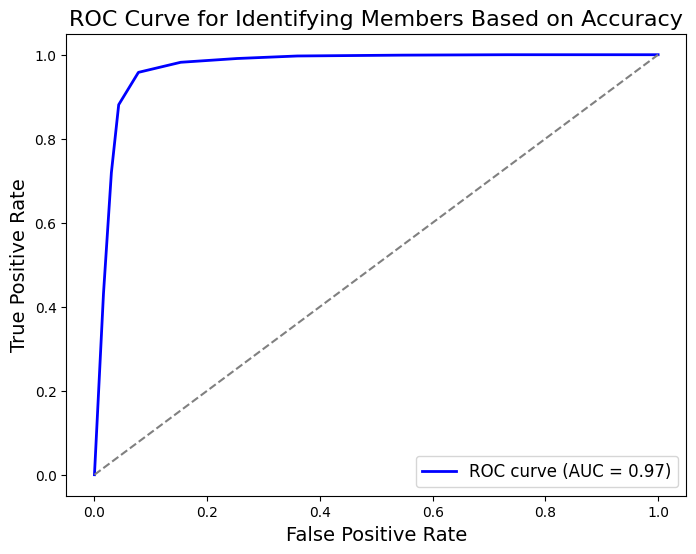

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Generate labels: 1 for members, 0 for non-members
labels = np.concatenate([np.ones(len(mem_acc)), np.zeros(len(nonmem_acc))])
scores = np.concatenate([mem_acc, nonmem_acc])

# Calculate FPR, TPR, and AUC
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference

# Labeling with larger font sizes
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Identifying Members Based on Accuracy', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()


Documents not retrieved in all questions' lists: ['MED-4483', 'MED-4775', 'MED-5368', 'MED-1405', 'MED-3789', 'MED-4284', 'MED-4000', 'MED-3245', 'MED-4382', 'MED-4756', 'MED-1833', 'MED-4757', 'MED-4296', 'MED-5161', 'MED-1563', 'MED-3988']


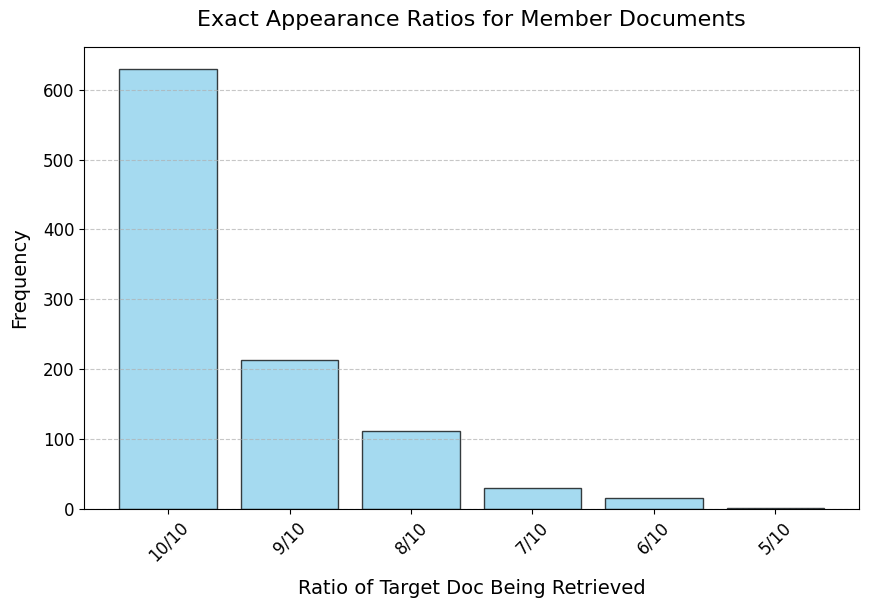

In [28]:
import json
import matplotlib.pyplot as plt
from collections import Counter

output_dir = 'results/target_docs'
output_file = f'{output_dir}/nfcorpus-llama3-Top10-M1000-N10.json'
with open(output_file, 'r') as f:
    data = json.load(f)

# Dictionary to store counts of exact appearance ratios
exact_counts = Counter()

# List to store document IDs that do not appear in all questions' retrieval lists
missing_full_retrieval_ids = []

# Loop through each target document in the JSON data, filtering by "mem": "yes"
for target_doc, item in data.items():
    if item.get("mem") == "yes":
        retrieved_doc_lists = item["retrieved_doc_ids"]
        
        # Count occurrences of the target document in its own retrieved doc lists
        count_in_retrieved = sum(1 for docs in retrieved_doc_lists if target_doc in docs)
        total_questions = len(retrieved_doc_lists)
        
        # Record the exact count (e.g., 10/10, 9/10)
        exact_counts[f"{count_in_retrieved}/{total_questions}"] += 1
        
        # Check if the target document does not appear in all retrieval lists
        if count_in_retrieved < total_questions-3:
            missing_full_retrieval_ids.append(target_doc)

# Output IDs that do not appear in all questions' retrieval lists
print("Documents not retrieved in all questions' lists:", missing_full_retrieval_ids)

# Prepare data for plotting
labels, values = zip(*sorted(exact_counts.items(), key=lambda x: int(x[0].split('/')[0]), reverse=True))

# Plotting the exact appearance ratio counts for member documents
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Ratio of Target Doc Being Retrieved', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Exact Appearance Ratios for Member Documents', fontsize=16, pad=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
